# VVS-XGBoost

In [15]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/train.csv")

In [16]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, explorative = True)
profile.to_file("Task1ProfileReport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 34/34 [00:04<00:00,  7.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
import numpy as np

df.drop(columns = ["id", "player_id"], inplace = True)
df = df.dropna(subset = ["is_cheater"])

from xgboost import XGBClassifier, DMatrix, train as xgb_train

X = df.drop("is_cheater", axis = 1)
y = df["is_cheater"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

# native XGBoost
dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [18]:
model = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Predictions: [1 0 0 ... 0 0 0]


In [19]:
from sklearn.metrics import fbeta_score

f2_macro = fbeta_score(y_test, y_pred, beta = 2, average = "macro")
f2_micro = fbeta_score(y_test, y_pred, beta = 2, average = "micro")
f2_weighted = fbeta_score(y_test, y_pred, beta = 2, average = "weighted")

print(f"F2 Macro: {f2_macro:.4f}")
print(f"F2 Micro: {f2_micro:.4f}")
print(f"F2 Weighted: {f2_weighted:.4f}")

F2 Macro: 0.7644
F2 Micro: 0.8041
F2 Weighted: 0.8007


In [20]:
importance_scores = model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance_scores
}).sort_values(by = "importance", ascending = False)

feat_importance

,feature,importance
30,crosshair_placement,0.228502
10,reports_received,0.195548
6,account_age_days,0.101007
9,friend_network_size,0.092826
7,level,0.061533
0,kill_death_ratio,0.031289
1,headshot_percentage,0.027607
20,game_sense_score,0.023645
3,accuracy_score,0.017301
19,spray_control_score,0.015208


In [21]:
weak_feature = feat_importance["feature"].tail(15).tolist()

In [22]:
X.drop(columns = weak_feature, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [23]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f2_macro = fbeta_score(y_test, y_pred, beta = 2, average = "macro")
f2_micro = fbeta_score(y_test, y_pred, beta = 2, average = "micro")
f2_weighted = fbeta_score(y_test, y_pred, beta = 2, average = "weighted")

print(f"F2 Macro: {f2_macro:.4f}")
print(f"F2 Micro: {f2_micro:.4f}")
print(f"F2 Weighted: {f2_weighted:.4f}")

F2 Macro: 0.7658
F2 Micro: 0.8067
F2 Weighted: 0.8030


In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
import optuna

f2_macro_scorer = make_scorer(fbeta_score, beta = 2, average = "macro")

def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "use_label_encoder": False,
        "objective": "multi:softmax",
        "num_class": 4,
        "eval_metric": "mlogloss",
        "n_jobs": -1,
        "random_state": 42
    }
    
    model = XGBClassifier(**param)
    
    # Stratified 5-fold CV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # Evaluate using F2 macro
    scores = cross_val_score(model, X, y, cv = cv, scoring = f2_macro_scorer)
    
    return scores.mean()

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50)

print("Best trial:")
trial = study.best_trial
print("F2 Macro:", trial.value)
print("Best hyperparameters:", trial.params)

[I 2025-11-28 05:07:17,053] A new study created in memory with name: no-name-c790f730-e715-4ed7-a526-b800cf3d607d
[I 2025-11-28 05:07:27,562] Trial 0 finished with value: 0.7619088803894627 and parameters: {'max_depth': 3, 'learning_rate': 0.2339039476595304, 'n_estimators': 121, 'subsample': 0.7951176246010083, 'colsample_bytree': 0.9565841028848683, 'gamma': 3.900032048251767, 'reg_alpha': 2.1716365248049216, 'reg_lambda': 3.0218781895715665}. Best is trial 0 with value: 0.7619088803894627.
[I 2025-11-28 05:08:07,000] Trial 1 finished with value: 0.7657016745992204 and parameters: {'max_depth': 10, 'learning_rate': 0.04564230328232159, 'n_estimators': 355, 'subsample': 0.5189118362716376, 'colsample_bytree': 0.7585659471346573, 'gamma': 2.5038573625988194, 'reg_alpha': 2.1580702547855934, 'reg_lambda': 1.6395407460369587}. Best is trial 1 with value: 0.7657016745992204.
[I 2025-11-28 05:08:16,869] Trial 2 finished with value: 0.7581223355034685 and parameters: {'max_depth': 8, 'learn

Best trial:
F2 Macro: 0.7670427552297412
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.09502306779774816, 'n_estimators': 407, 'subsample': 0.5441296871694551, 'colsample_bytree': 0.8023489318611722, 'gamma': 2.236678251235929, 'reg_alpha': 2.8940272572867385, 'reg_lambda': 1.8295240052755743}


In [24]:
best_params = study.best_params.copy()
best_params.update({
    "objective": "binary:logistic",
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": 42,
    "n_jobs": -1
})

f2_scorer = make_scorer(fbeta_score, beta = 2, average = "binary")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42
)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
model = XGBClassifier(**best_params)

In [25]:
cv_scores = cross_val_score(model, X_train, y_train, cv = cv, scoring = f2_scorer, n_jobs = -1)

print("CV F2 scores (train folds):", np.round(cv_scores, 4))
print("CV F2 mean:", np.round(cv_scores.mean(), 4))
print("CV F2 std:", np.round(cv_scores.std(), 4))

CV F2 scores (train folds): [0.6483 0.6485 0.6497 0.6507 0.652 ]
CV F2 mean: 0.6498
CV F2 std: 0.0014


In [26]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8023489318611722, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.236678251235929, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09502306779774816,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=407, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [27]:
inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/test.csv")

inference.drop(columns = ["id", "player_id"], inplace = True)
inference.drop(columns = weak_feature, inplace = True)

In [28]:
y_pred = model.predict(inference)
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")
submit["task1"] = y_pred
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")

# StackEnsemble

In [29]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/train.csv")

df.drop(columns = ["id", "player_id"], inplace = True)
df = df.dropna(subset = ["is_cheater"])

X = df.drop(columns = ["is_cheater"])
y = df["is_cheater"].astype(int)

## Feature Selection

In [30]:
from xgboost import XGBClassifier

xgb_for_fi = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False,
    random_state = 42,
    n_jobs = 1
)

xgb_for_fi.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=1, num_parallel_tree=None, random_state=42, ...)

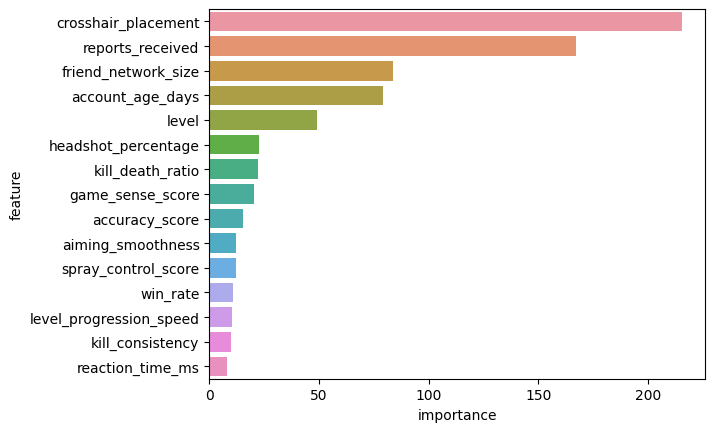

In [31]:
# Extract Feature Importance
booster = xgb_for_fi.get_booster()
fi = booster.get_score(importance_type = "gain")

import matplotlib.pyplot as plt
import seaborn as sns

fi_named = pd.DataFrame(fi.items(), columns = ["feature", "importance"])
Top15 = fi_named.sort_values("importance", ascending = False).head(15)

sns.barplot(data = Top15, y = "feature", x = "importance", orient = "h")
plt.show()

In [32]:
fi_named_sorted = fi_named.sort_values("importance", ascending = False)
fi_named_sorted["cumulative_importance"] = fi_named_sorted["importance"].cumsum() / fi_named_sorted["importance"].sum()
selected_features = fi_named_sorted[fi_named_sorted["cumulative_importance"] <= 0.95]["feature"]

print(f"Selected {len(selected_features)} features out of {len(fi_named)} total features")
X_selected = X[selected_features].copy()

Selected 24 features out of 31 total features


## Modeling

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

estimators = [
    ("XGBoost", XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "logloss",
        use_label_encoder = False,
        random_state = 42,
        n_jobs = 1
    )),
    ("LightGBM", LGBMClassifier(
        objective = "binary",
        metric = "binary_logloss",
        random_state = 42,
        n_jobs = 1
    )),
    ("CatBoost", CatBoostClassifier(
        loss_function = "Logloss",
        eval_metric = "Logloss",
        verbose = 0,
        random_state = 42,
        thread_count = 1
    ))
]

blender = LogisticRegression(solver = "saga", max_iter = 2000, random_state = 42)

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fbeta_scorer = make_scorer(fbeta_score, beta = 2, average = "binary")
scores = cross_val_score(stack, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
print(f"Stacking (XGB+LGBM+Cat -> LR): mean F2 = {scores.mean():.4f}  (+/- {scores.std():.4f})")

[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data 

## Hyperparameter

In [26]:
import optuna

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log = True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),

        "objective": "binary:logistic",
        "use_label_encoder": False,
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_xgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 100)
print("Best XGB params:", study_xgb.best_params, "best f2:", 1 - study_xgb.best_value)

[I 2025-11-28 05:58:41,878] A new study created in memory with name: no-name-51519c00-951a-4ef4-be68-8a2decb926f3
[I 2025-11-28 05:59:10,139] Trial 0 finished with value: 0.35592045924251203 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1618509290001068, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 2.5348407664333426e-07, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.35592045924251203.
[I 2025-11-28 05:59:42,557] Trial 1 finished with value: 0.37820963315607636 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.031456163175583855, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.899465584480253, 'gamma': 8.148018307012941e-07, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.35592045924251203.
[I 2025-11-28 05:59:57,609] Trial 2 finished with value: 0.3611971459471951 and parameters: 

Best XGB params: {'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.21686268622292826, 'subsample': 0.5525800241980569, 'colsample_bytree': 0.5864315116436489, 'gamma': 1.459068523957759, 'reg_alpha': 0.0005270933696306975, 'reg_lambda': 0.07852312052461549} best f2: 0.6575166974293205


In [27]:
def objective_lgb(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 6, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),

        "objective": "binary",
        "metric": "binary_logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_lgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_lgb.optimize(objective_lgb, n_trials = 100)
print("Best LGB params:", study_lgb.best_params, "best f2:", 1 - study_lgb.best_value)

[I 2025-11-28 06:46:58,333] A new study created in memory with name: no-name-12991c8d-d0dd-4b49-964a-63762a621479


[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2025-11-28 06:47:14,981] Trial 0 finished with value: 0.35112371447410085 and parameters: {'num_leaves': 52, 'min_child_samples': 96, 'learning_rate': 0.1618509290001068, 'n_estimators': 319, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.49359671220172163, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.35112371447410085.
[I 2025-11-28 06:47:44,873] Trial 1 finished with value: 0.3574138917767693 and parameters: {'num_leaves': 79, 'min_child_samples': 72, 'learning_rate': 0.031456163175583855, 'n_estimators': 487, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.5274034664069657, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 wi

[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[L

[I 2025-11-28 06:50:03,890] Trial 11 finished with value: 0.34524619010245416 and parameters: {'num_leaves': 119, 'min_child_samples': 5, 'learning_rate': 0.2947986009059022, 'n_estimators': 57, 'subsample': 0.9869601043141659, 'colsample_bytree': 0.9950907663814265, 'reg_alpha': 7.556243125116112, 'reg_lambda': 5.2052107279562385}. Best is trial 10 with value: 0.345190778052448.
[I 2025-11-28 06:50:11,389] Trial 12 finished with value: 0.3464557770411777 and parameters: {'num_leaves': 123, 'min_child_samples': 5, 'learning_rate': 0.19933580085944358, 'n_estimators': 51, 'subsample': 0.9917980782940604, 'colsample_bytree': 0.8577618901311783, 'reg_alpha': 9.41874879245652, 'reg_lambda': 0.05547786031884726}. Best is trial 10 with value: 0.345190778052448.
[I 2025-11-28 06:50:18,378] Trial 13 finished with value: 0.359078443010729 and parameters: {'num_leaves': 127, 'min_child_samples': 8, 'learning_rate': 0.09865579539940637, 'n_estimators': 54, 'subsample': 0.8731522909801657, 'colsam

[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] 

[I 2025-11-28 06:50:31,205] Trial 14 finished with value: 0.34327195601387583 and parameters: {'num_leaves': 101, 'min_child_samples': 29, 'learning_rate': 0.20946012406339398, 'n_estimators': 121, 'subsample': 0.996021339734391, 'colsample_bytree': 0.8654806210166778, 'reg_alpha': 0.6255688317185165, 'reg_lambda': 9.207736961357973}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:50:43,517] Trial 15 finished with value: 0.3504582724558599 and parameters: {'num_leaves': 99, 'min_child_samples': 32, 'learning_rate': 0.20034833018713577, 'n_estimators': 144, 'subsample': 0.9221534889950529, 'colsample_bytree': 0.8075588525957713, 'reg_alpha': 0.39909064972762814, 'reg_lambda': 0.06275624421868707}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:50:54,440] Trial 16 finished with value: 0.3538307824315797 and parameters: {'num_leaves': 96, 'min_child_samples': 38, 'learning_rate': 0.10762270410530717, 'n_estimators': 124, 'subsample': 0.8352725713024

[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [

[I 2025-11-28 06:51:07,594] Trial 17 finished with value: 0.34563776558859804 and parameters: {'num_leaves': 101, 'min_child_samples': 19, 'learning_rate': 0.20780617399132628, 'n_estimators': 125, 'subsample': 0.7220668180434928, 'colsample_bytree': 0.8887709727296994, 'reg_alpha': 0.0004590883367895594, 'reg_lambda': 8.131078351312306}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:51:26,436] Trial 18 finished with value: 0.35245526718419584 and parameters: {'num_leaves': 108, 'min_child_samples': 37, 'learning_rate': 0.13839385071978752, 'n_estimators': 226, 'subsample': 0.9478668969549888, 'colsample_bytree': 0.7764518959689806, 'reg_alpha': 0.039553805820462605, 'reg_lambda': 0.3683649250652756}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:51:36,300] Trial 19 finished with value: 0.36037742404288475 and parameters: {'num_leaves': 81, 'min_child_samples': 15, 'learning_rate': 0.07146892101381584, 'n_estimators': 114, 'subsample': 0.767823


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] 

[I 2025-11-28 06:51:55,393] Trial 20 finished with value: 0.34874317488589734 and parameters: {'num_leaves': 86, 'min_child_samples': 31, 'learning_rate': 0.22913914045667033, 'n_estimators': 245, 'subsample': 0.861815572925765, 'colsample_bytree': 0.917222815104249, 'reg_alpha': 0.00010396761370918986, 'reg_lambda': 0.5777437508670802}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:52:06,738] Trial 21 finished with value: 0.34552752439337886 and parameters: {'num_leaves': 114, 'min_child_samples': 11, 'learning_rate': 0.27032163429676376, 'n_estimators': 86, 'subsample': 0.9981126922026228, 'colsample_bytree': 0.9748468403715274, 'reg_alpha': 3.3023487211818527, 'reg_lambda': 6.538933290731444}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:52:16,160] Trial 22 finished with value: 0.34628597895723234 and parameters: {'num_leaves': 116, 'min_child_samples': 43, 'learning_rate': 0.29577675488488736, 'n_estimators': 86, 'subsample': 0.93691977260


[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] 

[I 2025-11-28 06:52:51,537] Trial 25 finished with value: 0.3544794041504037 and parameters: {'num_leaves': 128, 'min_child_samples': 5, 'learning_rate': 0.12697597510059924, 'n_estimators': 52, 'subsample': 0.9572142311251033, 'colsample_bytree': 0.8631430330500817, 'reg_alpha': 1.7133251672341698, 'reg_lambda': 2.487632698794177}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:53:01,671] Trial 26 finished with value: 0.34466041227957633 and parameters: {'num_leaves': 116, 'min_child_samples': 46, 'learning_rate': 0.23883515802751532, 'n_estimators': 94, 'subsample': 0.84375473407869, 'colsample_bytree': 0.7523616508623473, 'reg_alpha': 7.31516956222854, 'reg_lambda': 1.4747130072368995}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:53:15,644] Trial 27 finished with value: 0.3478591138995808 and parameters: {'num_leaves': 90, 'min_child_samples': 47, 'learning_rate': 0.23136152136237817, 'n_estimators': 205, 'subsample': 0.8364173367413742, 'c


[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:B

[I 2025-11-28 06:53:36,316] Trial 29 finished with value: 0.3560655280249013 and parameters: {'num_leaves': 66, 'min_child_samples': 30, 'learning_rate': 0.15837187726627797, 'n_estimators': 103, 'subsample': 0.8911472904119923, 'colsample_bytree': 0.6232931827415774, 'reg_alpha': 3.0439381964747037e-07, 'reg_lambda': 0.2125304593888528}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:54:04,795] Trial 30 finished with value: 0.35391018775072225 and parameters: {'num_leaves': 106, 'min_child_samples': 63, 'learning_rate': 0.06869612210277144, 'n_estimators': 330, 'subsample': 0.8427026952283718, 'colsample_bytree': 0.8372646594098372, 'reg_alpha': 2.4249713988677598e-08, 'reg_lambda': 0.7151276229467174}. Best is trial 14 with value: 0.34327195601387583.



[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 06:54:14,366] Trial 31 finished with value: 0.34448506273360435 and parameters: {'num_leaves': 119, 'min_child_samples': 16, 'learning_rate': 0.2487875906088435, 'n_estimators': 72, 'subsample': 0.9603903212252876, 'colsample_bytree': 0.9012364216581861, 'reg_alpha': 8.931247902933064, 'reg_lambda': 2.0975428420274427}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:54:25,145] Trial 32 finished with value: 0.3475774899094549 and parameters: {'num_leaves': 119, 'min_child_samples': 17, 'learning_rate': 0.2406826770069502, 'n_estimators': 91, 'subsample': 0.946712758405013, 'colsample_bytree': 0.8930116280368003, 'reg_alpha': 3.7912818021895283, 'reg_lambda': 0.13322787050096757}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:54:40,348] Trial 33 finished with value: 0.3462810769239957 and parameters: {'num_leaves': 113, 'min_child_samples': 29, 'learning_rate': 0.24603903573276795, 'n_estimators': 144, 'subsample': 0.9207891453175421


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 06:55:47,130] Trial 39 finished with value: 0.3539832941556944 and parameters: {'num_leaves': 35, 'min_child_samples': 35, 'learning_rate': 0.1700859485292446, 'n_estimators': 186, 'subsample': 0.9337227437587067, 'colsample_bytree': 0.6519804513447657, 'reg_alpha': 0.055887544602928, 'reg_lambda': 3.796229852684374e-05}. Best is trial 14 with value: 0.34327195601387583.



[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 06:56:22,743] Trial 40 finished with value: 0.3492263868597716 and parameters: {'num_leaves': 111, 'min_child_samples': 44, 'learning_rate': 0.29969022951164365, 'n_estimators': 485, 'subsample': 0.7713442114682522, 'colsample_bytree': 0.7307486019605397, 'reg_alpha': 0.0008311649356041842, 'reg_lambda': 5.531251073932811e-06}. Best is trial 14 with value: 0.34327195601387583.
[I 2025-11-28 06:56:32,309] Trial 41 finished with value: 0.34288142037420966 and parameters: {'num_leaves': 122, 'min_child_samples': 9, 'learning_rate': 0.26902133991222255, 'n_estimators': 65, 'subsample': 0.9755748989517207, 'colsample_bytree': 0.9552524858146166, 'reg_alpha': 9.119796653187974, 'reg_lambda': 8.80974244480979}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:56:42,617] Trial 42 finished with value: 0.3433404068871073 and parameters: {'num_leaves': 125, 'min_child_samples': 10, 'learning_rate': 0.2672223293715309, 'n_estimators': 73, 'subsample': 0.968012057754


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 06:57:18,295] Trial 45 finished with value: 0.34833872482613937 and parameters: {'num_leaves': 128, 'min_child_samples': 18, 'learning_rate': 0.2652494119391497, 'n_estimators': 103, 'subsample': 0.8944059436081964, 'colsample_bytree': 0.9660277089913349, 'reg_alpha': 1.7073980967731708, 'reg_lambda': 0.7652132968519625}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:57:26,063] Trial 46 finished with value: 0.35070038413407856 and parameters: {'num_leaves': 104, 'min_child_samples': 75, 'learning_rate': 0.19428067891074738, 'n_estimators': 70, 'subsample': 0.8696618530626404, 'colsample_bytree': 0.8792441111312298, 'reg_alpha': 0.2690830591637435, 'reg_lambda': 3.079283749904838}. Best is trial 41 with value: 0.34288142037420966.



[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[

[I 2025-11-28 06:57:37,779] Trial 47 finished with value: 0.36120940145561686 and parameters: {'num_leaves': 122, 'min_child_samples': 55, 'learning_rate': 0.05091201071377662, 'n_estimators': 131, 'subsample': 0.6771291535654584, 'colsample_bytree': 0.5306123057968023, 'reg_alpha': 9.350677221107256, 'reg_lambda': 0.022617784285899473}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:57:49,265] Trial 48 finished with value: 0.34381811557492203 and parameters: {'num_leaves': 116, 'min_child_samples': 88, 'learning_rate': 0.22642425728409288, 'n_estimators': 104, 'subsample': 0.5964192686896229, 'colsample_bytree': 0.9344345935749105, 'reg_alpha': 3.6931141395698073, 'reg_lambda': 0.3412828757911305}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:58:22,817] Trial 49 finished with value: 0.34872458724443045 and parameters: {'num_leaves': 96, 'min_child_samples': 10, 'learning_rate': 0.21117915832159834, 'n_estimators': 354, 'subsample': 0.574248360


[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] 

[I 2025-11-28 06:58:51,791] Trial 51 finished with value: 0.34463208543471613 and parameters: {'num_leaves': 116, 'min_child_samples': 87, 'learning_rate': 0.2361989681810032, 'n_estimators': 68, 'subsample': 0.9706707625680668, 'colsample_bytree': 0.9659934299342441, 'reg_alpha': 3.8343401346622716, 'reg_lambda': 1.0689247503530876}. Best is trial 41 with value: 0.34288142037420966.



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] 

[I 2025-11-28 06:59:00,360] Trial 52 finished with value: 0.34557941296614136 and parameters: {'num_leaves': 117, 'min_child_samples': 91, 'learning_rate': 0.2209594449857796, 'n_estimators': 66, 'subsample': 0.9779454354401145, 'colsample_bytree': 0.9665465621784151, 'reg_alpha': 3.5076166457715403, 'reg_lambda': 3.752560127114259}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:59:12,491] Trial 53 finished with value: 0.3487655269410598 and parameters: {'num_leaves': 112, 'min_child_samples': 88, 'learning_rate': 0.19329549141289415, 'n_estimators': 112, 'subsample': 0.9436078141989165, 'colsample_bytree': 0.9957275435103055, 'reg_alpha': 1.0412750521519287e-07, 'reg_lambda': 1.1751039758309043}. Best is trial 41 with value: 0.34288142037420966.
[I 2025-11-28 06:59:19,591] Trial 54 finished with value: 0.34745429757222324 and parameters: {'num_leaves': 105, 'min_child_samples': 81, 'learning_rate': 0.2596829125171214, 'n_estimators': 63, 'subsample': 0.99860824339


[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] 

[I 2025-11-28 07:00:32,179] Trial 60 finished with value: 0.3521327840587759 and parameters: {'num_leaves': 75, 'min_child_samples': 65, 'learning_rate': 0.09162480139746447, 'n_estimators': 133, 'subsample': 0.9075922566485118, 'colsample_bytree': 0.8474911418691712, 'reg_alpha': 1.9505512988804872, 'reg_lambda': 0.35322223713188117}. Best is trial 41 with value: 0.34288142037420966.



[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 07:00:43,524] Trial 61 finished with value: 0.34032837918702996 and parameters: {'num_leaves': 92, 'min_child_samples': 94, 'learning_rate': 0.25045367847909994, 'n_estimators': 115, 'subsample': 0.9529515087150552, 'colsample_bytree': 0.900959734103827, 'reg_alpha': 5.905000114813205, 'reg_lambda': 2.3034543546174433}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:00:55,216] Trial 62 finished with value: 0.34335118925142305 and parameters: {'num_leaves': 94, 'min_child_samples': 94, 'learning_rate': 0.2727614620365413, 'n_estimators': 116, 'subsample': 0.6924830003356016, 'colsample_bytree': 0.9042158563964322, 'reg_alpha': 5.102854245232571, 'reg_lambda': 4.279735949979552}. Best is trial 61 with value: 0.34032837918702996.



[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 07:01:06,396] Trial 63 finished with value: 0.34682177750738585 and parameters: {'num_leaves': 92, 'min_child_samples': 94, 'learning_rate': 0.27998647003981186, 'n_estimators': 123, 'subsample': 0.6741137688293573, 'colsample_bytree': 0.8785467436391264, 'reg_alpha': 1.1560311494236306, 'reg_lambda': 5.054740415718698}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:01:27,578] Trial 64 finished with value: 0.34218863251301823 and parameters: {'num_leaves': 87, 'min_child_samples': 83, 'learning_rate': 0.2722642147306096, 'n_estimators': 246, 'subsample': 0.725337919249504, 'colsample_bytree': 0.9039792707892551, 'reg_alpha': 5.725708998136799, 'reg_lambda': 2.3292123615290308}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:01:47,329] Trial 65 finished with value: 0.34423509171036926 and parameters: {'num_leaves': 88, 'min_child_samples': 82, 'learning_rate': 0.2010779818425732, 'n_estimators': 253, 'subsample': 0.7298952269298569,


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] 

[I 2025-11-28 07:02:18,233] Trial 66 finished with value: 0.34414325706371396 and parameters: {'num_leaves': 74, 'min_child_samples': 98, 'learning_rate': 0.24917745892200982, 'n_estimators': 440, 'subsample': 0.701116149623907, 'colsample_bytree': 0.8230915734761333, 'reg_alpha': 2.4235387627926634, 'reg_lambda': 9.522441500842294}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:02:33,390] Trial 67 finished with value: 0.3437068407908701 and parameters: {'num_leaves': 84, 'min_child_samples': 94, 'learning_rate': 0.2678740541750852, 'n_estimators': 170, 'subsample': 0.647852543393386, 'colsample_bytree': 0.9546987810336806, 'reg_alpha': 6.120974404320246, 'reg_lambda': 0.12735303806482345}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:02:42,165] Trial 68 finished with value: 0.34777497200992014 and parameters: {'num_leaves': 94, 'min_child_samples': 85, 'learning_rate': 0.22303596043487056, 'n_estimators': 88, 'subsample': 0.7561685647409486, 


[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] 

[I 2025-11-28 07:03:40,182] Trial 71 finished with value: 0.344297662465211 and parameters: {'num_leaves': 100, 'min_child_samples': 70, 'learning_rate': 0.2856491309232422, 'n_estimators': 143, 'subsample': 0.9512095098141462, 'colsample_bytree': 0.89868114862815, 'reg_alpha': 2.6909507535621224, 'reg_lambda': 2.3280222364024676}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:03:50,533] Trial 72 finished with value: 0.34063279597347984 and parameters: {'num_leaves': 78, 'min_child_samples': 78, 'learning_rate': 0.29731545737885695, 'n_estimators': 114, 'subsample': 0.9884525554187811, 'colsample_bytree': 0.909116555751429, 'reg_alpha': 4.73516338442365, 'reg_lambda': 5.5025938130188425}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:04:00,980] Trial 73 finished with value: 0.34200665908888916 and parameters: {'num_leaves': 79, 'min_child_samples': 78, 'learning_rate': 0.26495126361171933, 'n_estimators': 116, 'subsample': 0.9846221000515608, '


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 07:04:09,390] Trial 74 finished with value: 0.3434778911853128 and parameters: {'num_leaves': 79, 'min_child_samples': 79, 'learning_rate': 0.2999353730601661, 'n_estimators': 86, 'subsample': 0.9865563474118653, 'colsample_bytree': 0.8569632360783349, 'reg_alpha': 9.897176840060155, 'reg_lambda': 5.981681124711304}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:04:21,847] Trial 75 finished with value: 0.3441737012152658 and parameters: {'num_leaves': 72, 'min_child_samples': 77, 'learning_rate': 0.2566272789466457, 'n_estimators': 158, 'subsample': 0.9991610897741712, 'colsample_bytree': 0.8803121616606102, 'reg_alpha': 5.494722737795176, 'reg_lambda': 1.5632611191263566}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:04:34,957] Trial 76 finished with value: 0.3488989472906159 and parameters: {'num_leaves': 61, 'min_child_samples': 59, 'learning_rate': 0.22425107947236886, 'n_estimators': 196, 'subsample': 0.9422914521642409, 'co


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 07:05:10,127] Trial 79 finished with value: 0.345958936051857 and parameters: {'num_leaves': 71, 'min_child_samples': 85, 'learning_rate': 0.2630012373003222, 'n_estimators': 111, 'subsample': 0.9711518134987379, 'colsample_bytree': 0.9792479048511002, 'reg_alpha': 2.4781709043347733, 'reg_lambda': 1.3135453865505402}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:05:18,023] Trial 80 finished with value: 0.3467682109184166 and parameters: {'num_leaves': 78, 'min_child_samples': 22, 'learning_rate': 0.20783332192049847, 'n_estimators': 80, 'subsample': 0.9359915337280518, 'colsample_bytree': 0.8844353994779606, 'reg_alpha': 5.576036618864216, 'reg_lambda': 0.20571175068384046}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:05:29,304] Trial 81 finished with value: 0.3424674081170712 and parameters: {'num_leaves': 86, 'min_child_samples': 96, 'learning_rate': 0.2821617918658902, 'n_estimators': 121, 'subsample': 0.7788506827133017, '


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 07:05:42,384] Trial 82 finished with value: 0.3474333609924718 and parameters: {'num_leaves': 91, 'min_child_samples': 7, 'learning_rate': 0.23643085900930813, 'n_estimators': 129, 'subsample': 0.9562188820393311, 'colsample_bytree': 0.8454625489892917, 'reg_alpha': 1.431879557810485, 'reg_lambda': 9.868274851888076}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:05:53,952] Trial 83 finished with value: 0.3433954083000449 and parameters: {'num_leaves': 63, 'min_child_samples': 76, 'learning_rate': 0.2807129787817263, 'n_estimators': 149, 'subsample': 0.9917939704526285, 'colsample_bytree': 0.9495554454494028, 'reg_alpha': 5.989729036971919, 'reg_lambda': 2.3749782251034333}. Best is trial 61 with value: 0.34032837918702996.
[I 2025-11-28 07:06:03,538] Trial 84 finished with value: 0.34563528540465127 and parameters: {'num_leaves': 86, 'min_child_samples': 12, 'learning_rate': 0.25566769893054686, 'n_estimators': 96, 'subsample': 0.8965482931886516, 'c


[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] 

[I 2025-11-28 07:07:38,378] Trial 90 finished with value: 0.36341492754250837 and parameters: {'num_leaves': 69, 'min_child_samples': 100, 'learning_rate': 0.030005071596438695, 'n_estimators': 192, 'subsample': 0.7836668711591713, 'colsample_bytree': 0.8894084014436439, 'reg_alpha': 0.8370211824092175, 'reg_lambda': 2.062610822353217e-07}. Best is trial 85 with value: 0.34029798535268463.
[I 2025-11-28 07:07:51,362] Trial 91 finished with value: 0.34329888723704016 and parameters: {'num_leaves': 80, 'min_child_samples': 75, 'learning_rate': 0.2796889388186378, 'n_estimators': 160, 'subsample': 0.7482402329464157, 'colsample_bytree': 0.9069862464454147, 'reg_alpha': 3.085407053070585, 'reg_lambda': 5.539123751048258e-08}. Best is trial 85 with value: 0.34029798535268463.
[I 2025-11-28 07:08:03,821] Trial 92 finished with value: 0.3424829541182669 and parameters: {'num_leaves': 81, 'min_child_samples': 72, 'learning_rate': 0.2891964839949472, 'n_estimators': 141, 'subsample': 0.76073687


[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] Start training from score -0.622731
[LightGBM] 

[I 2025-11-28 07:08:50,396] Trial 95 finished with value: 0.3429184444426887 and parameters: {'num_leaves': 82, 'min_child_samples': 72, 'learning_rate': 0.29122136263713555, 'n_estimators': 262, 'subsample': 0.7418677525885268, 'colsample_bytree': 0.8733969311150274, 'reg_alpha': 3.650919182433814, 'reg_lambda': 3.927991083557594e-08}. Best is trial 85 with value: 0.34029798535268463.



[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] 

[I 2025-11-28 07:08:59,025] Trial 96 finished with value: 0.34681620183346074 and parameters: {'num_leaves': 44, 'min_child_samples': 97, 'learning_rate': 0.2546602429247544, 'n_estimators': 137, 'subsample': 0.723086743435382, 'colsample_bytree': 0.9396003234076723, 'reg_alpha': 1.7990341443176419, 'reg_lambda': 2.421976757860675e-08}. Best is trial 85 with value: 0.34029798535268463.
[I 2025-11-28 07:09:11,296] Trial 97 finished with value: 0.3381045616806586 and parameters: {'num_leaves': 70, 'min_child_samples': 50, 'learning_rate': 0.299156108531212, 'n_estimators': 151, 'subsample': 0.7838482131531566, 'colsample_bytree': 0.9174826176446363, 'reg_alpha': 9.993983178238395, 'reg_lambda': 7.530055719606666e-08}. Best is trial 97 with value: 0.3381045616806586.
[I 2025-11-28 07:09:24,380] Trial 98 finished with value: 0.34189567476223537 and parameters: {'num_leaves': 80, 'min_child_samples': 85, 'learning_rate': 0.298958594913991, 'n_estimators': 152, 'subsample': 0.785805650815456

Best LGB params: {'num_leaves': 70, 'min_child_samples': 50, 'learning_rate': 0.299156108531212, 'n_estimators': 151, 'subsample': 0.7838482131531566, 'colsample_bytree': 0.9174826176446363, 'reg_alpha': 9.993983178238395, 'reg_lambda': 7.530055719606666e-08} best f2: 0.6618954383193414


In [28]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log = True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0,
        "thread_count" = -1
    }

    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_cat = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_cat.optimize(objective_cat, n_trials = 100)
print("Best Cat params:", study_cat.best_params, "best f2:", 1 - study_cat.best_value)

[I 2025-11-28 07:09:34,756] A new study created in memory with name: no-name-c399e419-560d-4035-806e-3cd005fd75a3



[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349148 -> initscore=-0.622788
[LightGBM] [Info] Start training from score -0.622788
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] 

[I 2025-11-28 07:12:13,513] Trial 0 finished with value: 0.36406536275185974 and parameters: {'iterations': 1249, 'learning_rate': 0.2678154091306088, 'depth': 8, 'l2_leaf_reg': 0.0024430162614261413, 'border_count': 66}. Best is trial 0 with value: 0.36406536275185974.
[I 2025-11-28 07:14:35,761] Trial 1 finished with value: 0.36781489391792055 and parameters: {'iterations': 636, 'learning_rate': 0.034292951628939645, 'depth': 9, 'l2_leaf_reg': 0.002570603566117598, 'border_count': 190}. Best is trial 0 with value: 0.36406536275185974.
[I 2025-11-28 07:15:19,953] Trial 2 finished with value: 0.37689675283712165 and parameters: {'iterations': 257, 'learning_rate': 0.27991818073277003, 'depth': 9, 'l2_leaf_reg': 8.148018307012941e-07, 'border_count': 72}. Best is trial 0 with value: 0.36406536275185974.
[I 2025-11-28 07:16:38,279] Trial 3 finished with value: 0.3655929343607658 and parameters: {'iterations': 713, 'learning_rate': 0.060445433652475976, 'depth': 7, 'l2_leaf_reg': 7.718006


[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349152 -> initscore=-0.622768
[LightGBM] [Info] Start training from score -0.622768
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] 

[I 2025-11-28 10:42:23,738] Trial 67 finished with value: 0.37136451720154573 and parameters: {'iterations': 2653, 'learning_rate': 0.24879120796378146, 'depth': 10, 'l2_leaf_reg': 0.001986919224235607, 'border_count': 187}. Best is trial 61 with value: 0.3431158803158195.
[I 2025-11-28 10:45:18,441] Trial 68 finished with value: 0.346323037303106 and parameters: {'iterations': 2161, 'learning_rate': 0.2654330922713878, 'depth': 5, 'l2_leaf_reg': 0.004032583462468385, 'border_count': 160}. Best is trial 61 with value: 0.3431158803158195.
[I 2025-11-28 10:48:26,453] Trial 69 finished with value: 0.34872684486109407 and parameters: {'iterations': 2321, 'learning_rate': 0.20918887885005333, 'depth': 5, 'l2_leaf_reg': 0.02981002933668723, 'border_count': 156}. Best is trial 61 with value: 0.3431158803158195.
[I 2025-11-28 10:51:42,310] Trial 70 finished with value: 0.34770122163531725 and parameters: {'iterations': 2425, 'learning_rate': 0.17733198566646918, 'depth': 5, 'l2_leaf_reg': 0.00

Best Cat params: {'iterations': 2577, 'learning_rate': 0.2969267956922033, 'depth': 4, 'l2_leaf_reg': 0.0007228750065433437, 'border_count': 169} best f2: 0.6568841196841805


In [40]:
from sklearn.model_selection import KFold
import copy

def get_oof_preds(model, X, y, cv):
    oof_preds = np.zeros((X.shape[0], len(np.unique(y))))  # For predict_proba
    models = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        clf = copy.deepcopy(model)
        clf.fit(X_train, y_train)
        oof_preds[val_idx] = clf.predict_proba(X_val)
        models.append(clf)
        
    return oof_preds, models

# Prepare CV
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Prepare sanitized base models
xgb_model = XGBClassifier(**sanitize_xgb_params(study_xgb.best_params))
lgb_model = LGBMClassifier(**sanitize_lgb_params(study_lgb.best_params))
cat_model = CatBoostClassifier(**sanitize_cat_params(study_cat.best_params))

# Generate OOF predictions
xgb_oof, xgb_models = get_oof_preds(xgb_model, X_selected, y, cv)
lgb_oof, lgb_models = get_oof_preds(lgb_model, X_selected, y, cv)
cat_oof, cat_models = get_oof_preds(cat_model, X_selected, y, cv)

# Stack them as features for the final model
X_blender = np.hstack([xgb_oof, lgb_oof, cat_oof])

[LightGBM] [Info] Number of positive: 27405, number of negative: 50793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350457 -> initscore=-0.617033
[LightGBM] [Info] Start training from score -0.617033
[LightGBM] [Info] Number of positive: 27302, number of negative: 50896
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349139 -> initscore=-0.622824
[LightGBM] [Info] Start training from score -0.622824
[LightGBM] [

In [41]:
def objective_final(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2"])
    
    final_clf = LogisticRegression(
        C=C,
        penalty=penalty,
        solver="saga",
        max_iter=2000,
        random_state=42
    )
    
    scores = cross_val_score(final_clf, X_blender, y, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
    return 1.0 - scores.mean()

study_final = optuna.create_study(direction = "minimize", sampler=optuna.samplers.TPESampler(seed = 42))
study_final.optimize(objective_final, n_trials = 50)

print("Best final model params:", study_final.best_params)
print("Best F2 score:", 1 - study_final.best_value)

[I 2025-11-28 21:12:04,510] A new study created in memory with name: no-name-7cecceb0-8dad-497e-b126-f7bedeafc8d8
[I 2025-11-28 21:12:07,861] Trial 0 finished with value: 0.3430137414057878 and parameters: {'C': 0.017670169402947963, 'penalty': 'l2'}. Best is trial 0 with value: 0.3430137414057878.
[I 2025-11-28 21:12:09,670] Trial 1 finished with value: 0.3416462166265658 and parameters: {'C': 50.61576888752309, 'penalty': 'l2'}. Best is trial 1 with value: 0.3416462166265658.
[I 2025-11-28 21:12:11,225] Trial 2 finished with value: 0.34166390261157376 and parameters: {'C': 2.465832945854912, 'penalty': 'l2'}. Best is trial 1 with value: 0.3416462166265658.
[I 2025-11-28 21:12:12,615] Trial 3 finished with value: 0.3416532588780783 and parameters: {'C': 0.39079671568228835, 'penalty': 'l2'}. Best is trial 1 with value: 0.3416462166265658.
[I 2025-11-28 21:12:14,045] Trial 4 finished with value: 0.3640599369402593 and parameters: {'C': 0.0008632008168602544, 'penalty': 'l2'}. Best is t

Best final model params: {'C': 0.207382692884503, 'penalty': 'l2'}
Best F2 score: 0.6584763971714374


In [42]:
print(study_xgb.best_params)
print(study_lgb.best_params)
print(study_cat.best_params)

print(study_blender.best_params)

{'n_estimators': 491, 'max_depth': 5, 'learning_rate': 0.21686268622292826, 'subsample': 0.5525800241980569, 'colsample_bytree': 0.5864315116436489, 'gamma': 1.459068523957759, 'reg_alpha': 0.0005270933696306975, 'reg_lambda': 0.07852312052461549}
{'num_leaves': 70, 'min_child_samples': 50, 'learning_rate': 0.299156108531212, 'n_estimators': 151, 'subsample': 0.7838482131531566, 'colsample_bytree': 0.9174826176446363, 'reg_alpha': 9.993983178238395, 'reg_lambda': 7.530055719606666e-08}
{'iterations': 2577, 'learning_rate': 0.2969267956922033, 'depth': 4, 'l2_leaf_reg': 0.0007228750065433437, 'border_count': 169}
{'C': 0.017670169402947963, 'penalty': 'l2'}


## Evaluation

In [52]:
from sklearn.model_selection import cross_val_predict

xgb_best = study_xgb.best_params
lgb_best = study_lgb.best_params
cat_best = study_cat.best_params
blender_best = study_blender.best_params

# --- Base models ---
xgb_final = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False,
    random_state = 42,
    n_jobs = 1,
    **xgb_best
)

lgb_final = LGBMClassifier(
    objective = "binary",
    random_state = 42,
    n_jobs = 1,
    **lgb_best
)

cat_final = CatBoostClassifier(
    loss_function = "Logloss",
    eval_metric = "Logloss",
    verbose = 0,
    random_state = 42,
    thread_count = 1,
    **cat_best
)

blender = LogisticRegression(
    solver = "saga",
    max_iter = 5000,
    random_state = 42,
    **blender_best
)

# --- Stacking classifier ---
estimators = [
    ("XGBoost", xgb_final),
    ("LightGBM", lgb_final),
    ("CatBoost", cat_final)
]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

# --- Cross-validated predictions ---
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
y_proba_oof = cross_val_predict(stack, X_selected, y, cv = cv, 
                                method = "predict_proba", n_jobs = -1)[:, 1]

[LightGBM] [Info] Number of positive: 27135, number of negative: 51064
[LightGBM] [Info] Number of positive: 27335, number of negative: 50863
[LightGBM] [Info] Number of positive: 27302, number of negative: 50896
[LightGBM] [Info] Number of positive: 27405, number of negative: 50793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.346999 -> initscore=-0.632255
[LightGBM] [Info] Start training from score -0.632255
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data 

OOF F2 score: 0.8148


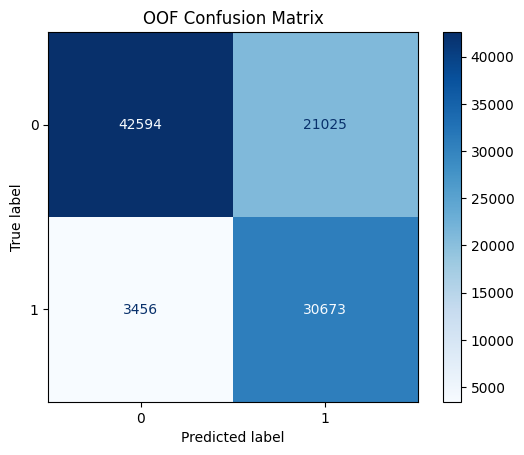

OOF Classification Report:
              precision    recall  f1-score   support

           0     0.9250    0.6695    0.7768     63619
           1     0.5933    0.8987    0.7148     34129

    accuracy                         0.7495     97748
   macro avg     0.7591    0.7841    0.7458     97748
weighted avg     0.8092    0.7495    0.7551     97748



In [53]:
threshold = 0.2
y_pred_oof = (y_proba_oof >= threshold).astype(int)

beta = 2
f2 = fbeta_score(y, y_pred_oof, beta = beta)
print(f"OOF F{beta} score: {f2:.4f}")

# Confusion matrix
cm = confusion_matrix(y, y_pred_oof)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues")
plt.title("OOF Confusion Matrix")
plt.show()

# Classification report
print("OOF Classification Report:")
print(classification_report(y, y_pred_oof, digits=4))

## Inference

In [18]:
import pandas as pd

inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/test.csv")
inference.drop(columns = ["id", "player_id"], inplace = True)

X_test = inference[selected_features].copy()

# X_selected = X.copy()
# X_test = inference.copy()

In [19]:
xgb_best = study_xgb.best_params
lgb_best = study_lgb.best_params
cat_best = study_cat.best_params
blender_best = study_blender.best_params

xgb_final = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False,
    random_state = 42,
    n_jobs = 1,
    **xgb_best
)

lgb_final = LGBMClassifier(
    objective = "binary",
    random_state = 42,
    n_jobs = 1,
    **lgb_best
)

cat_final = CatBoostClassifier(
    loss_function = "Logloss",
    eval_metric = "Logloss",
    verbose = 0,
    random_state = 42,
    thread_count = 1,
    **cat_best
)

blender = LogisticRegression(
    solver = "saga",
    max_iter = 5000,
    random_state = 42,
    **blender_best
)

In [20]:
estimators = [
    ("XGBoost", xgb_final),
    ("LightGBM", lgb_final),
    ("CatBoost", cat_final)
]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

print("Training STACK with best params...")
stack.fit(X_selected, y)
print("DONE retraining with best parameters!")

Training STACK with best params...
[LightGBM] [Info] Number of positive: 27304, number of negative: 50895
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Number of positive: 27303, number of negative: 50895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 78198, number of used features: 24
[LightGBM] [Info] Number of data points in the train set: 78199, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349160 -> initscore=-0.622731
[LightGBM] [Info] [bina

In [21]:
probs = stack.predict_proba(X_test)[:, 1]
preds = (probs >= 0.2).astype(int)
print("Predictions ready!")

Predictions ready!


In [22]:
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")

submit["task1"] = preds
submit.to_csv("ThreeTreeStackEnsembleHyperparameter0.2.csv", index = False)

[LightGBM] [Info] Number of positive: 34129, number of negative: 63619
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5655
[LightGBM] [Info] Number of data points in the train set: 97748, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.349153 -> initscore=-0.622765
[LightGBM] [Info] Start training from score -0.622765
